In [1]:
%pylab inline
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf
import numpy as np
# Set notebook mode to work in offline
import plotly.offline as pyo
pyo.init_notebook_mode()

#from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

from numpy import pi

class Particle_Tracking_Training_Data(tf.Module):
    def __init__(self, Nt, rings=True):
        self.Nt = int(Nt)
        self.Ny = self.Nx = 256
        self.d = 3
        ximg = [[[i, j] for i in np.arange(self.Ny)]
            for j in np.arange(self.Nx)]
        self.ximg = np.float32(ximg)

        x = np.arange(self.Nx) - self.Nx//2
        y = np.arange(self.Ny) - self.Ny//2
        X0, Y0 = np.meshgrid(x, y)
        self.X = np.float32(X0)
        self.Y = np.float32(Y0)

        if rings:
            self.ring_indicator = 1.
        else:
            self.ring_indicator = 0.

        self._gen_video = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),)
        )(self._gen_video)

        self._gen_labels = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),)
        )(self._gen_labels)

    def __call__(self, kappa, a, IbackLevel, Nparticles, sigma_motion):
        """a: spot radius scale factor (1.5-4 is a reasonable range)
        kappa: noise level (around 0.1 or so)
        IbackLevel: intensity level of the random background relative to maximum (must be between zero and one)
        Nparticles: the number of particles in the video (larger numbers means slower run time)
        sigma_motion: the standard deviation of the random Brownian motion per video frame"""
        ## random brownian motion paths
        ## Nt, Nparticles, 3
        xi = self._sample_motion(Nparticles, sigma_motion)

        #### translate track positions to img coords
        ## Ny, Nx, Nt, Np, 2
        XALL = (self.ximg[:, :, None, None, :]
                - xi[None, None, :, :, :2])
        ## Ny, Nx, Nt, Np
        r = tf.math.sqrt(XALL[..., 0]**2 + XALL[..., 1]**2)
        z = xi[..., 2]

        ### generate video
        I = self._gen_video(r, z, kappa, a, IbackLevel)

        ### generate labels
        labels = self._gen_labels(r)

        return I, labels, xi

    @staticmethod
    def rand(n):
        return tf.random.uniform([n], dtype=tf.float32)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),))
    def _sample_motion(self, Nparticles, sigma_motion):
        #### boundaries
        b_lower = tf.constant(
            [-10, -10, -30.], tf.float32)
        b_upper = tf.constant(
            [self.Nx+10, self.Ny+10, 30.], tf.float32)
        #### uniform random initial possitions
        U = tf.random.uniform(
            [1, Nparticles, self.d],
            dtype=tf.float32)
        X0 = b_lower + (b_upper - b_lower)*U
        #### normal increments
        dX = tf.random.normal(
            [self.Nt, Nparticles, self.d],
            stddev=sigma_motion,
            dtype=tf.float32)
        #### unbounded Brownian motion
        X = X0 + tf.math.cumsum(dX, axis=0)
        #### reflected brownian motion
        ## note that this is imperfect,
        ## if increments are very large it wont work
        X = tf.math.abs(X - b_lower) + b_lower
        X = -tf.math.abs(b_upper - X) + b_upper
        return X

    def _gen_video(self, r, z, kappa, a, IbackLevel):
        uw = (0.5 + self.rand(1))/2.
        un = tf.floor(3*self.rand(1))
        uampRing = 0.2 + 0.8*self.rand(1)
        ufade = 15 + 10*self.rand(1)
        rmax = ufade*(un/uw)**(2./3.)
        ufadeMax = 0.85
        fade = (1. - ufadeMax*tf.abs(tf.tanh(z/ufade)))
        core = tf.exp(-(r**2/(8.*a))**2)
        ring = fade*(tf.exp(-(r - z)**4/(a)**4)
                + 0.5*uampRing*tf.cast(r<z, tf.float32))
        I = tf.transpose(
            tf.reduce_sum(
                fade*(core + self.ring_indicator*ring),
                axis=3),
            [2, 0, 1]) # Nt, Ny, Nx
        I += IbackLevel*tf.sin(
            self.rand(1)*6*pi/512*tf.sqrt(
                self.rand(1)*(self.X - self.rand(1)*512)**2
                    + self.rand(1)*(self.Y - self.rand(1)*512)**2))
        I += tf.random.normal(
            [self.Nt, self.Ny, self.Nx],
            stddev=kappa,
            dtype=tf.float32)
        Imin = tf.reduce_min(I)
        Imax = tf.reduce_max(I)
        I = (I - Imin)/(Imax - Imin)
        I = tf.round(I*tf.maximum(float32(256.), tf.cast(tf.round(2**16*self.rand(1)), dtype='float32')))
        #I = tf.round(I*tf.maximum(256., tf.round(float32(2**16*self.rand(1)))))
        return I

    def _gen_labels(self, r):
        R_detect = 3.
        ## (Ny, Nx, Nt)
        detectors = tf.reduce_sum(
            tf.cast(r[::2, ::2, :, :] < R_detect, tf.int32),
            axis=3)
        ## (Nt, Ny, Nx)
        P = tf.transpose(
            tf.cast(detectors > 0, tf.int32), [2, 0, 1])
        ## (Nt, Ny, Nx, 2)
        labels = tf.stack([1-P, P], 3)
        return labels


# Procedurally generated training data
The code below demonstrates how to generate training videos and labels. The function also returns the ground truth particle tracks, which might also be useful depending on your goals.

Note that the training generator is a Tensorflow Module and can be easily incorperated into a Tensorflow neural network. Alternatively, you could simply save a large set of data and use another machine learning framework.

Note that the image dimension is fixed at 256x256. The labels are downsampled to 128x128 in the image dimensions. There are two classes (a particle is detected or not detected) per label so the label shape is 128x128x2. Hence, the neural network output should be 128x128x2.

### Our paper
https://www.pnas.org/content/115/36/9026.short

In [3]:
Nt = 10 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

## Visualizing training videos and labels

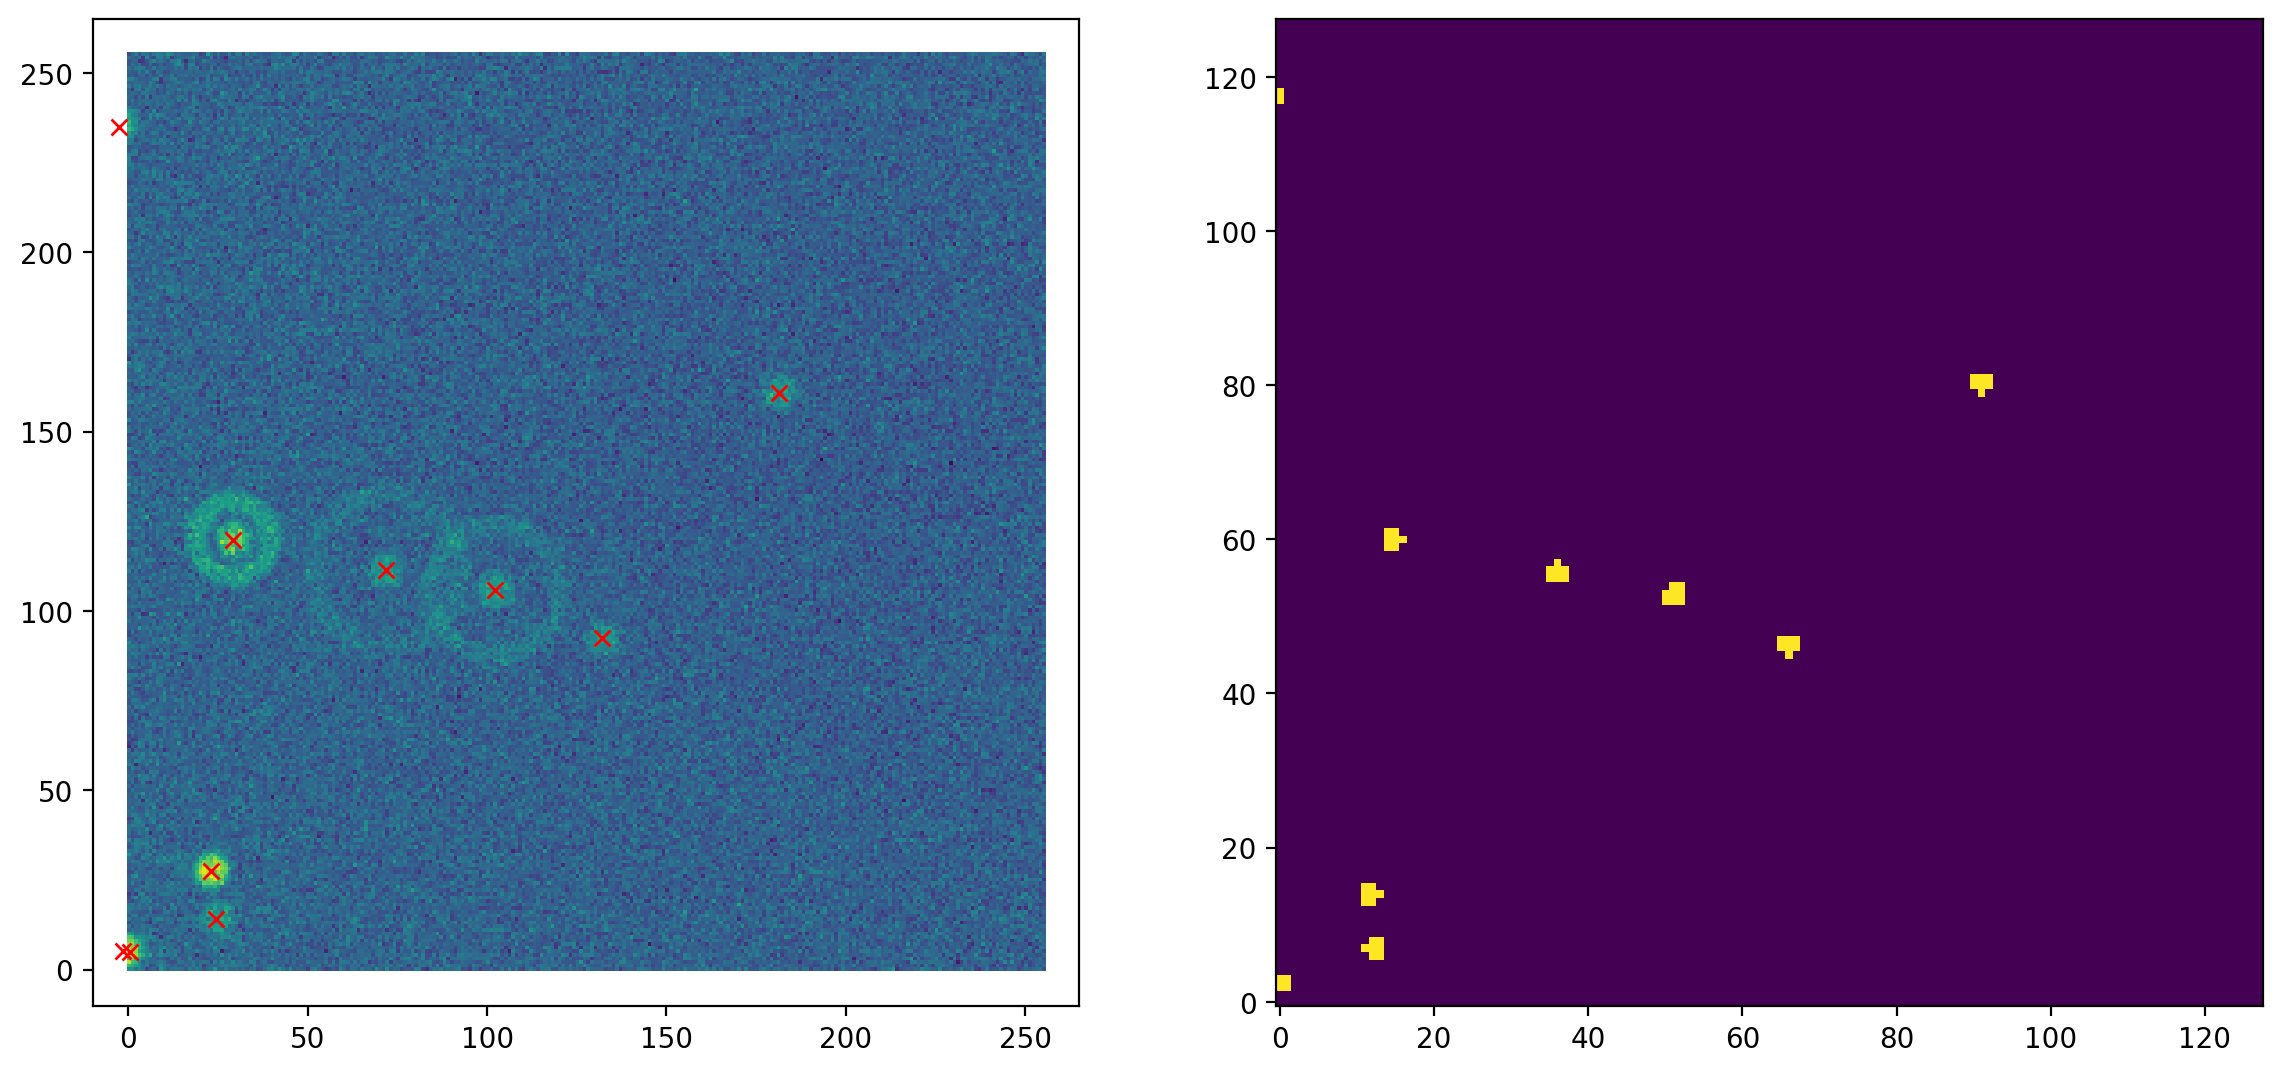

interactive(children=(IntSlider(value=0, description='t', max=9), Checkbox(value=True, description='show_track…

In [4]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')


### Particle tracks

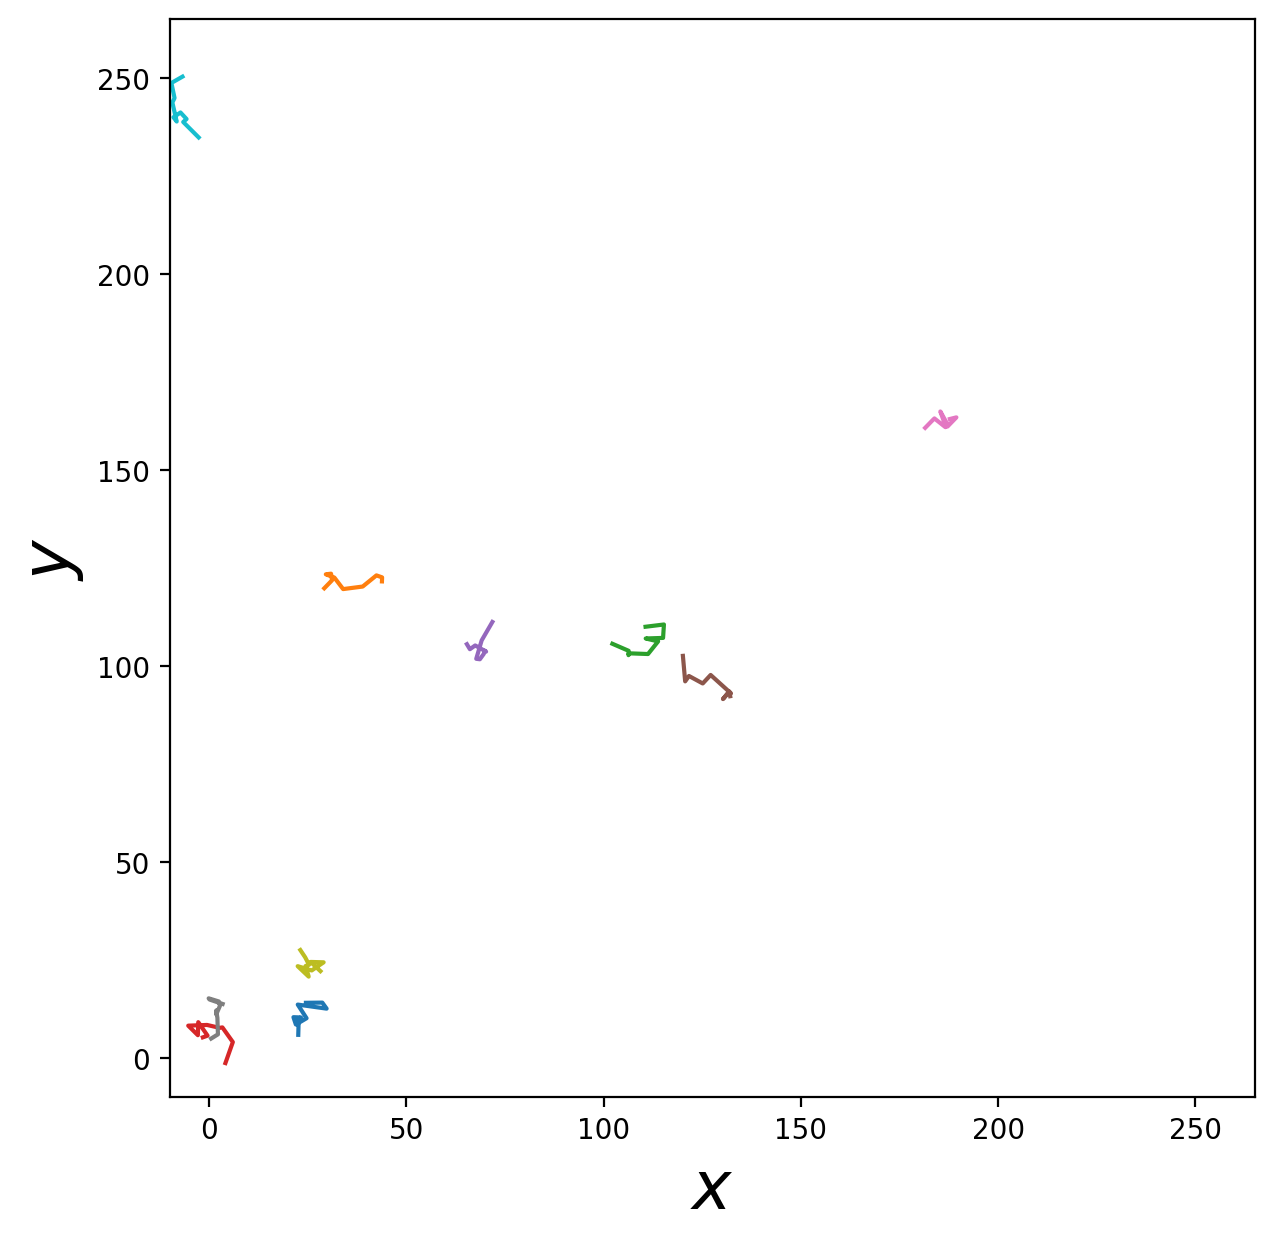

In [5]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
xlim(-10, 265)
ylim(-10, 265)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Goal 1: Design and train a convolutional neural network using the training data generator

# Goal 2: Given ground truth labels, extract particle positions in each video frame
Simply stated, given `labels` approximate `tracks`. So this project essentially ignores the training videos.

## Does your method work for hypothetical neural network output?
The neural network output is a probability distribution with values between zero and one.

# Goal 3: Given a video and particle positions (from the training data generator) develop a neural network to estimate the z-position of each particle
This one is somewhat speculative. It should be possible, but I have not tried it myself.

In [6]:
from tensorflow.keras import layers, models, optimizers
from tensorflow import feature_column as fc
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


In [7]:
# A function which will take the upper and lower bounds and create boundaries of our containers,
# an array with the mean of each container, and the class names
def create_range(lower_bound = -30, upper_bound = 30, classes = 10):
    distance = (upper_bound - lower_bound) / classes
    boundaries = []
    class_dot = []
    class_names = []
    
    for a in range(1, classes):
        boundaries.append(lower_bound + distance * (a))
        
    for a in range(1, classes + 1):
        class_dot.append(lower_bound + distance / 2 + distance * (a - 1))
        class_names.append(str(lower_bound + (a - 1) * distance) + " to " + str(lower_bound + a * distance) )
    return boundaries, class_dot, class_names

In [8]:
# network and training
EPOCHS = 100
BATCH_SIZE = 64
#BATCH_SIZE = 32
VERBOSE = 1
#Test score: 0.5499149560928345
#Test accuracy: 0.8381452560424805
OPTIMIZER = tf.keras.optimizers.Adam()

#Test score: 1.0488522052764893
#Test accuracy: 0.609375
#OPTIMIZER = tf.keras.optimizers.Adagrad()

#Test score: 2.304302453994751
#Test accuracy: 0.10472659766674042
#OPTIMIZER = tf.keras.optimizers.Ftrl()

#Test score: 0.7305694818496704
#Test accuracy: 0.7151730060577393
#OPTIMIZER = tf.keras.optimizers.RMSprop()

#Test score: 0.8334560394287109
#Test accuracy: 0.6860869526863098
#OPTIMIZER = tf.keras.optimizers.SGD()

VALIDATION_SPLIT=0.3
#WIDTH = 32
WIDTH = 48
IMG_ROWS, IMG_COLS = WIDTH, WIDTH
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)
DROPOUT = 0.2

NB_CLASSES = 15
BOUNDARIES, class_dot, class_names = create_range(classes=NB_CLASSES)


In [9]:
# this function takes x; y; and z coordinates, as well a single image from the video, and returns a image width x width
# image and the z dimention for training/testing purposes
def grab_image(x, y, z, video, width):
    d = int(width / 2)
    single_image = video[int(y - d): int(y + d), int(x - d): int(x + d)] / 20000
    return (single_image, z)

In [10]:
# load training images and labels
train_images = []
train_labels = []
edge = WIDTH / 2
for t in range(1500):
    vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
    for p in range(Nparticles):
        if (tracks[0, p, 0] > edge) and (tracks[0, p, 0] < 255 - edge) and (tracks[0, p, 1] > edge) and (tracks[0, p, 1] < 255 - edge):
            temp_img, temp_z = grab_image(x = int(tracks[0, p, 0]), y = int(tracks[0, p, 1]), z = int(tracks[0, p, 2]),video = vid[0, ...], width = WIDTH)
            train_images.append(temp_img)
            train_labels.append(temp_z)
#         else:
#             pass
#     if t % 100 == 0:
#         print(t)
#         pass

In [11]:
# Code for labels One-Hot Encoding
def encodeLabels(labels, bound, classes):
    for l in range(len(labels)):
        for b in range(len(bound)):
            if labels[l] < bound[b]:
                labels[l] = np.zeros(classes)
                labels[l][b] = 1
                break
            else:
                if b == len(bound) - 1:
                    labels[l] = np.zeros(classes)
                    labels[l][b + 1] = 1
                    break
    return labels

In [12]:
# A function to Plot a small image sample
def plotsmall(t=0, show_tracks=True):
    fig = figure(1, [7, 7])  
    fig.add_subplot(122)
    imshow(train_images[t], origin='lower')

In [13]:
train_labels = encodeLabels(train_labels, BOUNDARIES, NB_CLASSES)
train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)
train_images = train_images.reshape(len(train_images), IMG_ROWS, IMG_COLS, 1)

In [14]:
#define the convolutional network
# Network design based on various samples from Deep Learning with TensorFlow 2 and Keras
# Citation is included in the report

def build_model(input_shape, classes):
    model = models.Sequential()
    
    # 1st block
    model.add(layers.Conv2D(16, (3,3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    # 2nd block
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))
    
    # 3rd block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))
    
    # dense
    model.add(layers.Flatten())
    # Categorical
    model.add(layers.Dense(classes, activation='softmax'))
    
    return model

In [15]:
model = build_model(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        34,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,263 (419.00 KB)

 Trainable params: 106,815 (417.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Make sure to desplay logs if needed
callbacks = tf.keras.callbacks.TensorBoard(log_dir='.logs')

In [17]:
# Train the network
history = model.fit(train_images, train_labels,
                   batch_size=BATCH_SIZE, epochs=EPOCHS,
                   verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
                   callbacks=callbacks)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1659 - loss: 3.6676 - val_accuracy: 0.0683 - val_loss: 3.0784
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.4271 - loss: 1.8263 - val_accuracy: 0.1090 - val_loss: 2.9271
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5242 - loss: 1.4722 - val_accuracy: 0.2487 - val_loss: 2.4230
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5623 - loss: 1.3043 - val_accuracy: 0.3979 - val_loss: 1.9189
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5893 - loss: 1.1898 - val_accuracy: 0.4453 - val_loss: 1.8531
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6338 - loss: 1.0613 - val_accuracy: 0.5144 - val_loss: 1.3780
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6480 - loss: 0.9718 - val_accuracy: 0.6293 - val_loss: 1.0479
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6528 - loss: 0.9480 - val_accuracy: 0

In [18]:
# setup a test invironment for our trained network
ptest = Particle_Tracking_Training_Data(1)
vid, labels, tracks = ptest(kappa, a, IbackLevel, Nparticles, sigma_motion)

In [19]:
test_images = []
test_labels = []
for t in range(500):
    vid, labels, tracks = ptest(kappa, a, IbackLevel, Nparticles, sigma_motion)
    for p in range(Nparticles):
        if (tracks[0, p, 0] > edge) and (tracks[0, p, 0] < 255 - edge) and (tracks[0, p, 1] > edge) and (tracks[0, p, 1] < 255 - edge):
            temp_img, temp_z = grab_image(x = tracks[0, p, 0], y = tracks[0, p, 1], z = tracks[0, p, 2],video = vid[0, ...], width = WIDTH)
            test_images.append(temp_img)
            test_labels.append(temp_z)


In [20]:
numerical_labels = test_labels.copy()
test_labels = encodeLabels(test_labels, BOUNDARIES, NB_CLASSES)
test_np_labels = test_labels.copy()

In [21]:
test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)
test_images = test_images.reshape(len(test_images), IMG_ROWS, IMG_COLS, 1)

In [22]:
# Run a test which evaluates with the traditional Tensorflow method
score = model.evaluate(test_images, test_labels, verbose=VERBOSE)
print("\nTest score:", score[0])
print("\nTest accuracy:", score[1])

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6826 - loss: 1.3032

Test score: 1.2925165891647339

Test accuracy: 0.6780086159706116


In [23]:
# methods for plotting predictions retrieved from and example at:
# https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(NB_CLASSES))
    plt.yticks([])
    thisplot = plt.bar(range(NB_CLASSES), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[int(true_label)].set_color('blue')


In [24]:
# a function to correctly align images for our predictions
def labels_to_index(label):
    give_back = -1
    for i in range(len(label)):
        if label[i] == 1:
            give_back = i
            break
    return int(give_back)

In [25]:
predictions = model.predict(test_images)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [26]:
indexed_labels = []
for j in range(len(test_labels)):
    indexed_labels.append(labels_to_index(test_labels[j]))

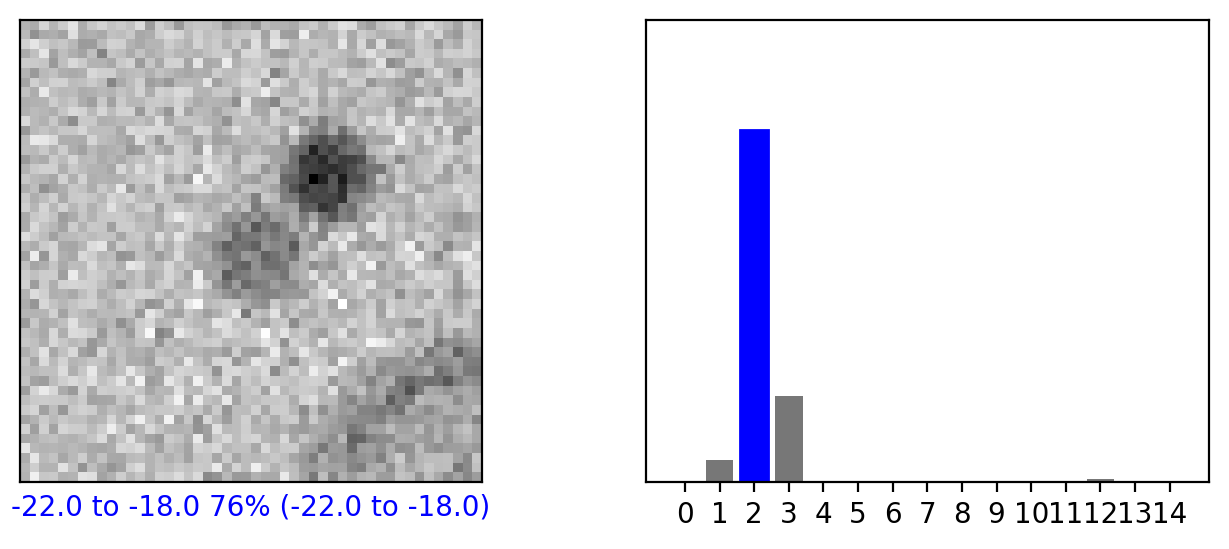

Difference between prediction and label: 0.292


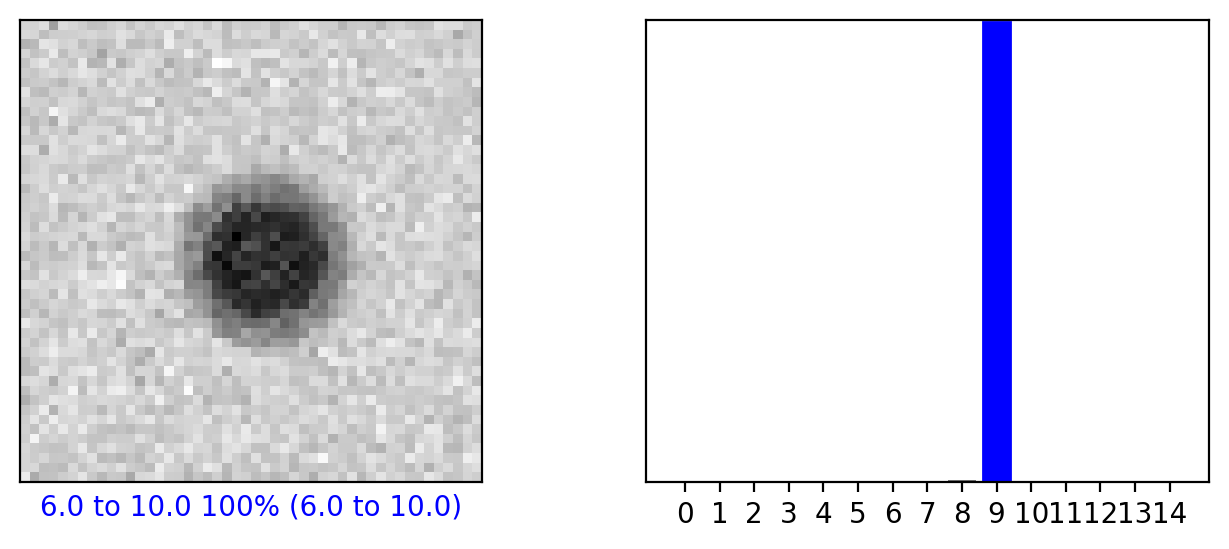

Difference between prediction and label: 1.73


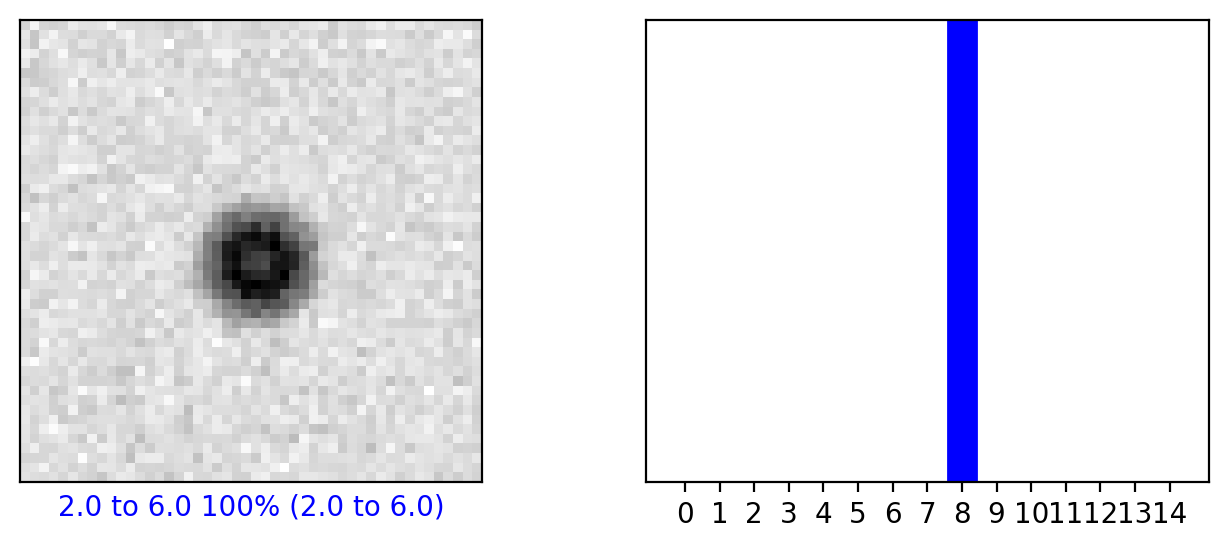

Difference between prediction and label: 0.141


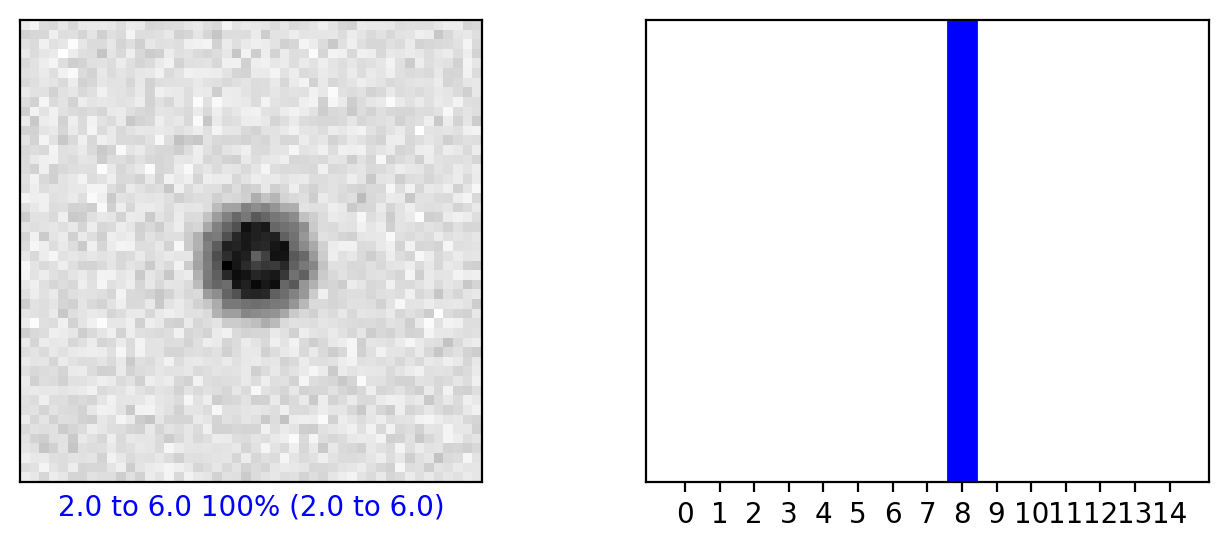

Difference between prediction and label: 0.215


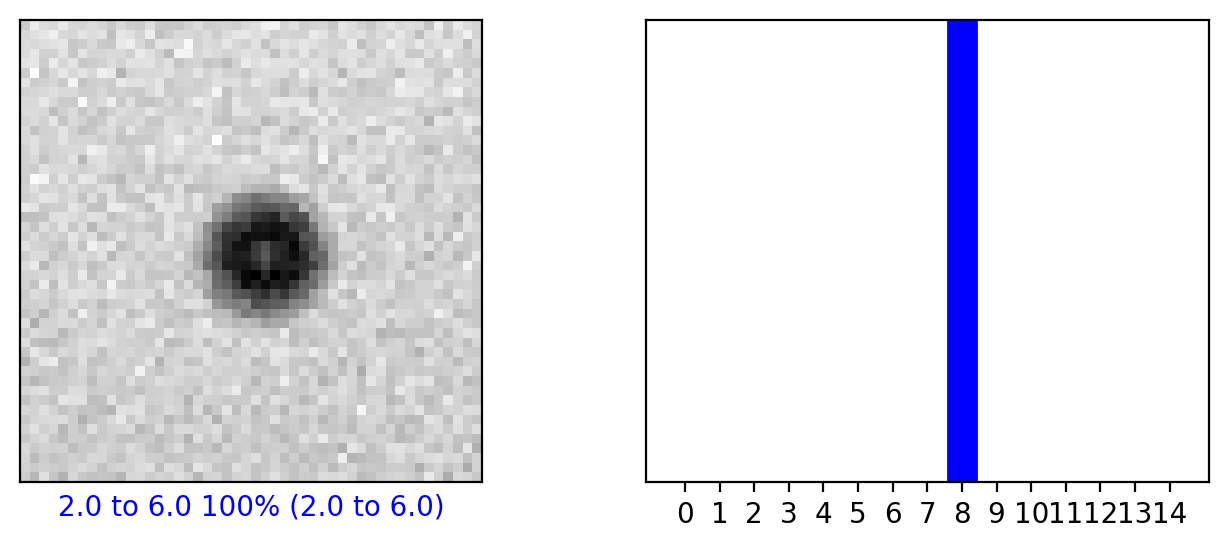

Difference between prediction and label: 0.0808


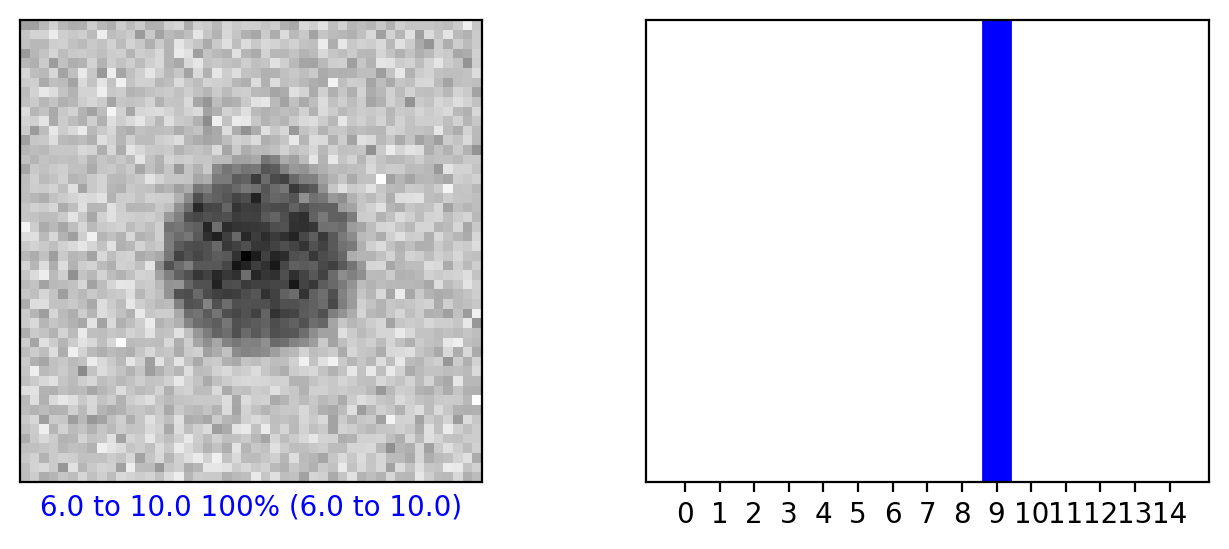

Difference between prediction and label: 0.734


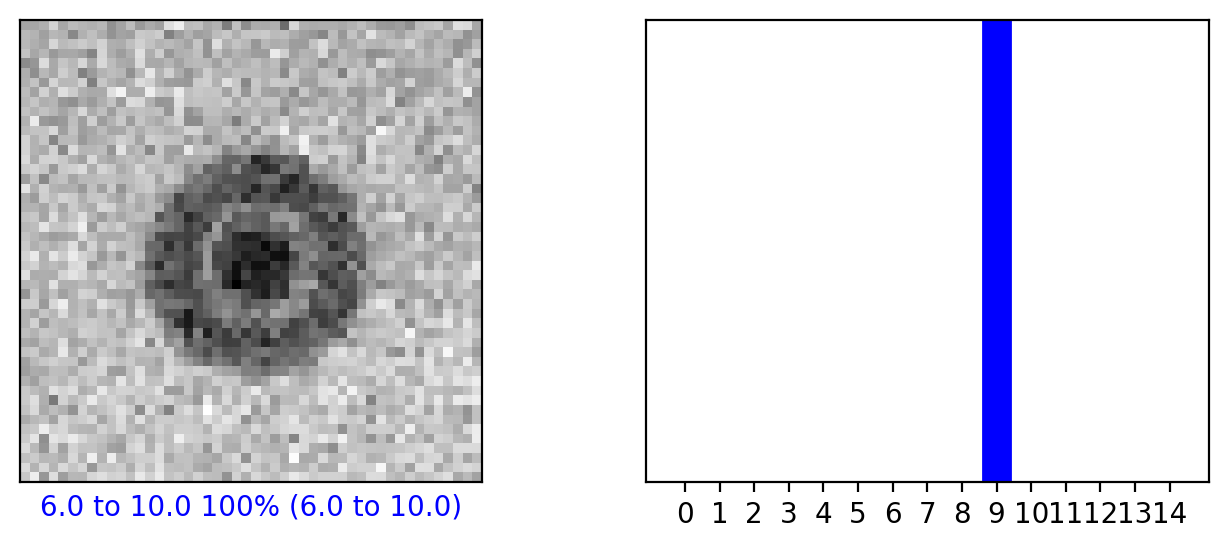

Difference between prediction and label: 0.935


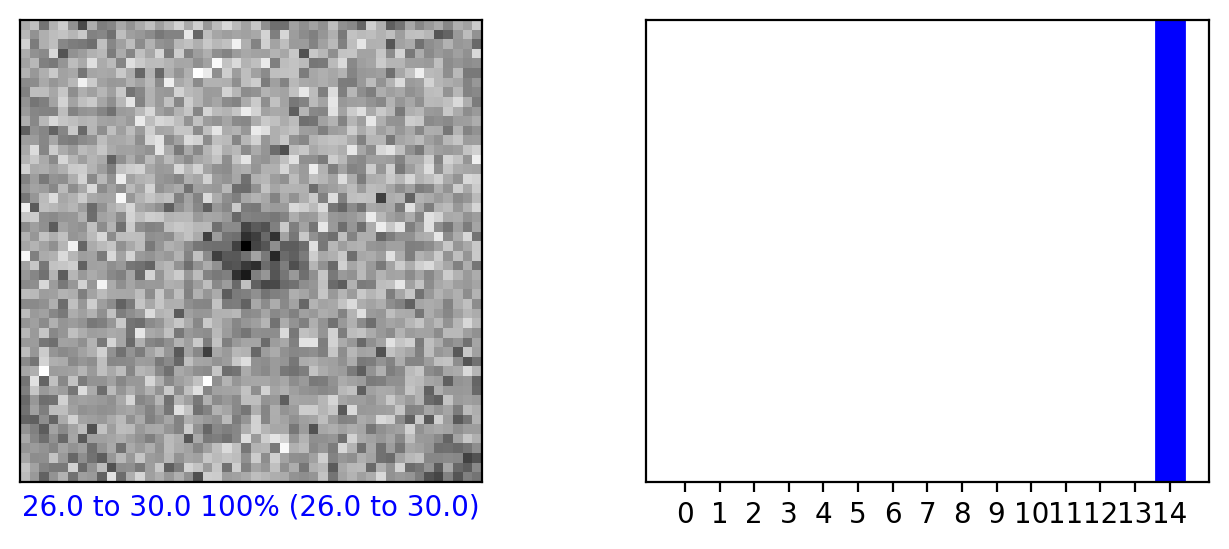

Difference between prediction and label: 1.58


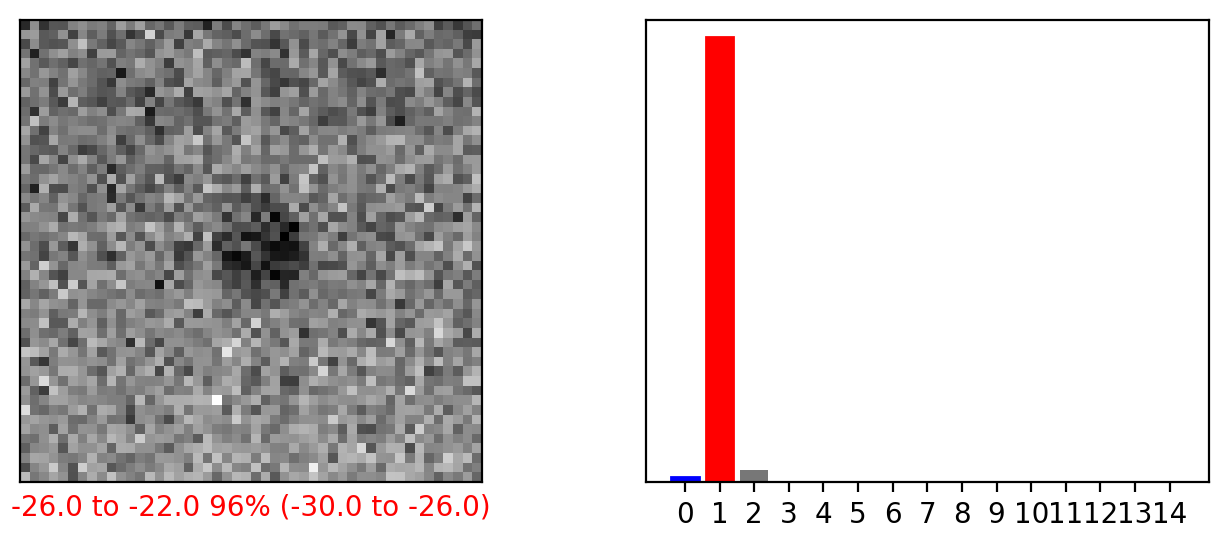

Difference between prediction and label: 2.56


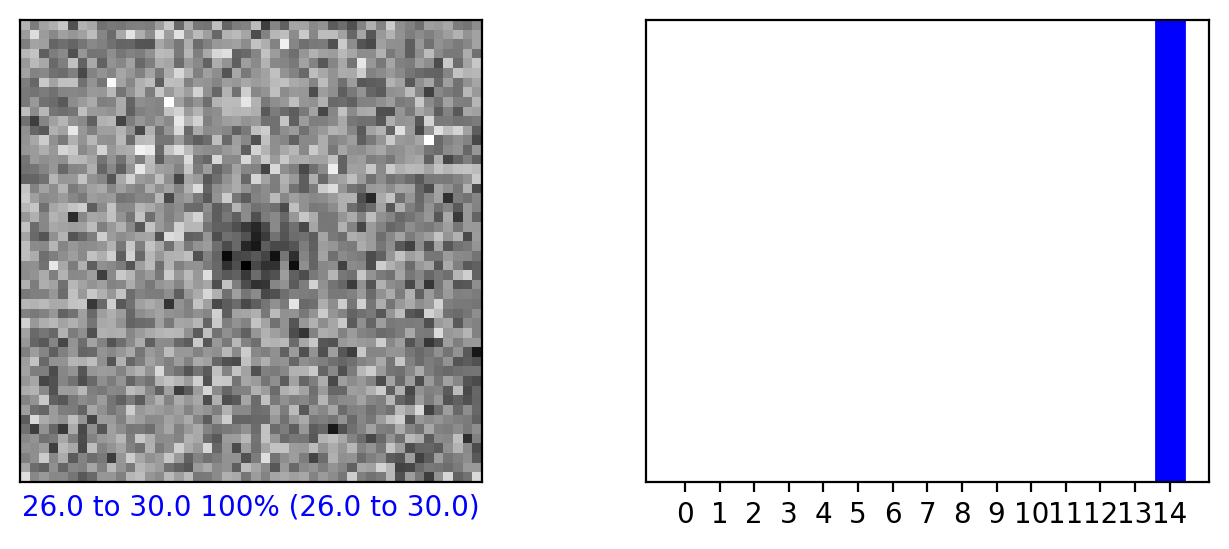

Difference between prediction and label: 0.437


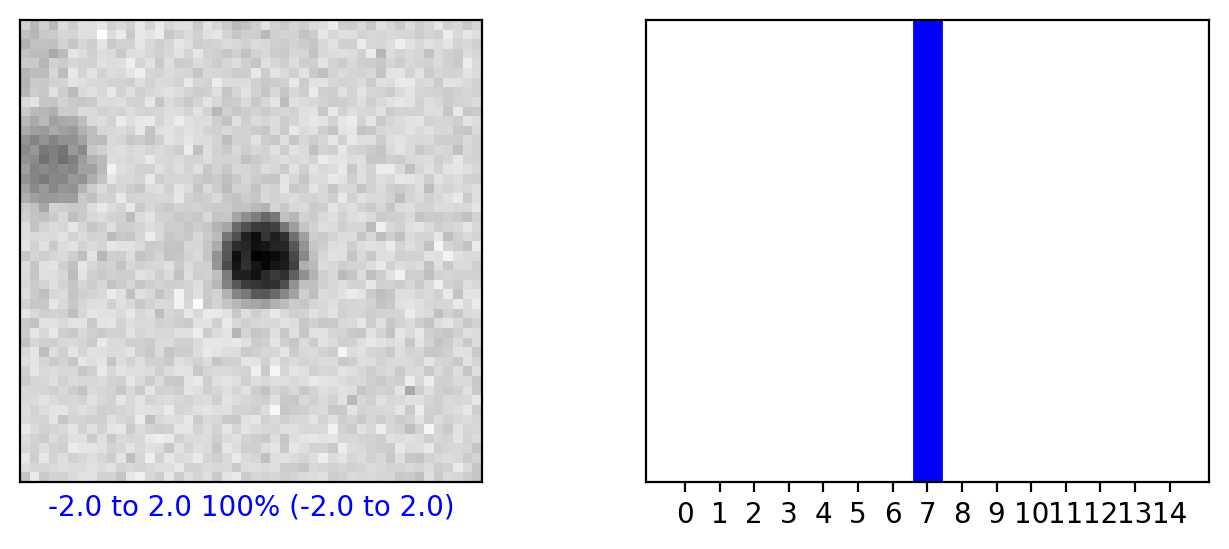

Difference between prediction and label: 1.25


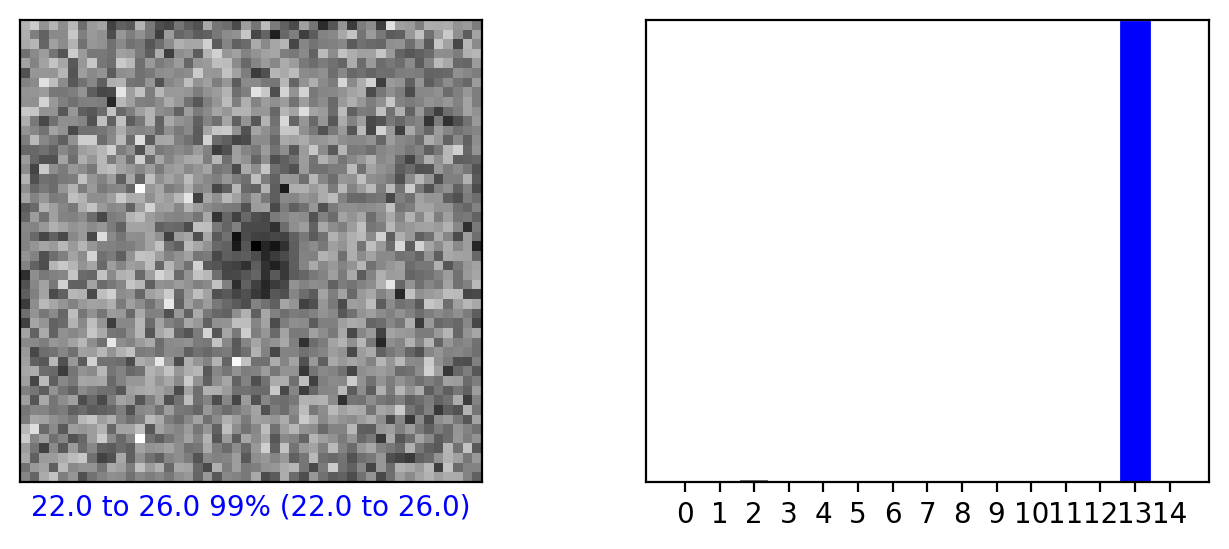

Difference between prediction and label: 0.937


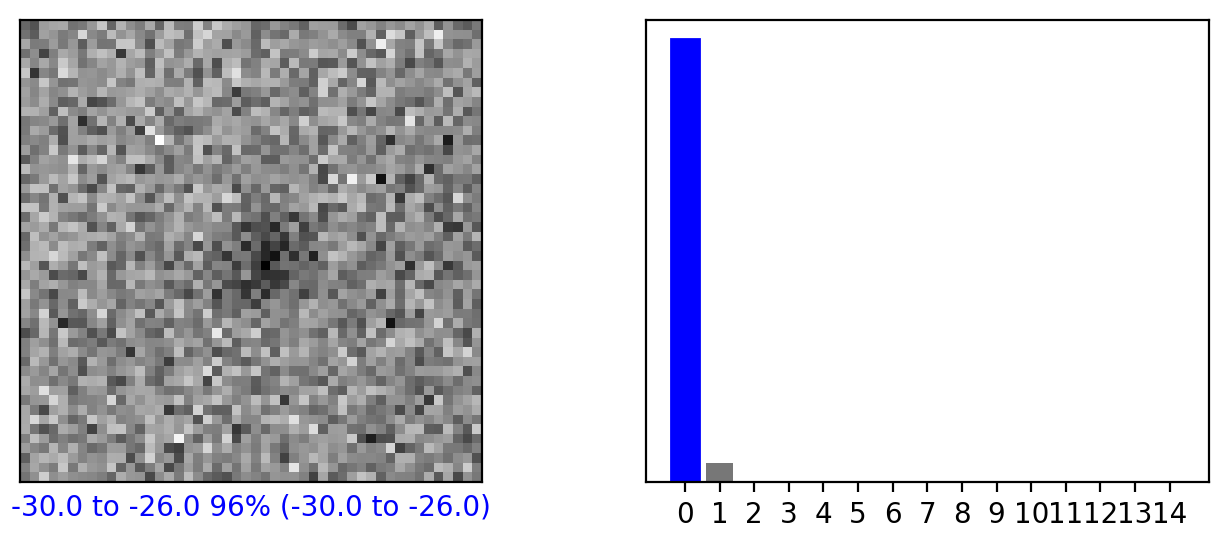

Difference between prediction and label: 1.88


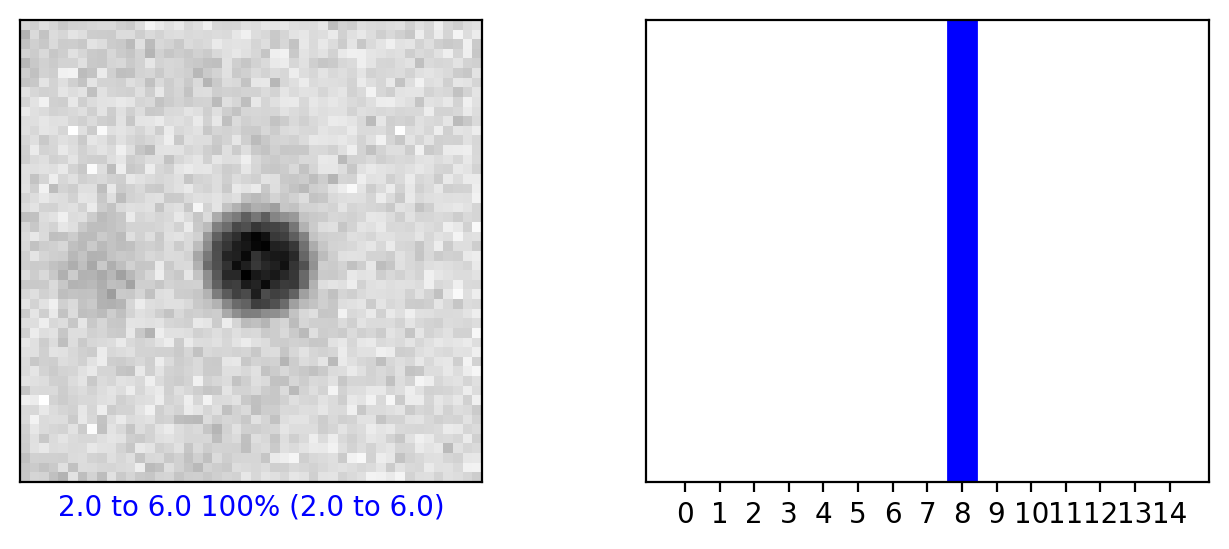

Difference between prediction and label: 0.896


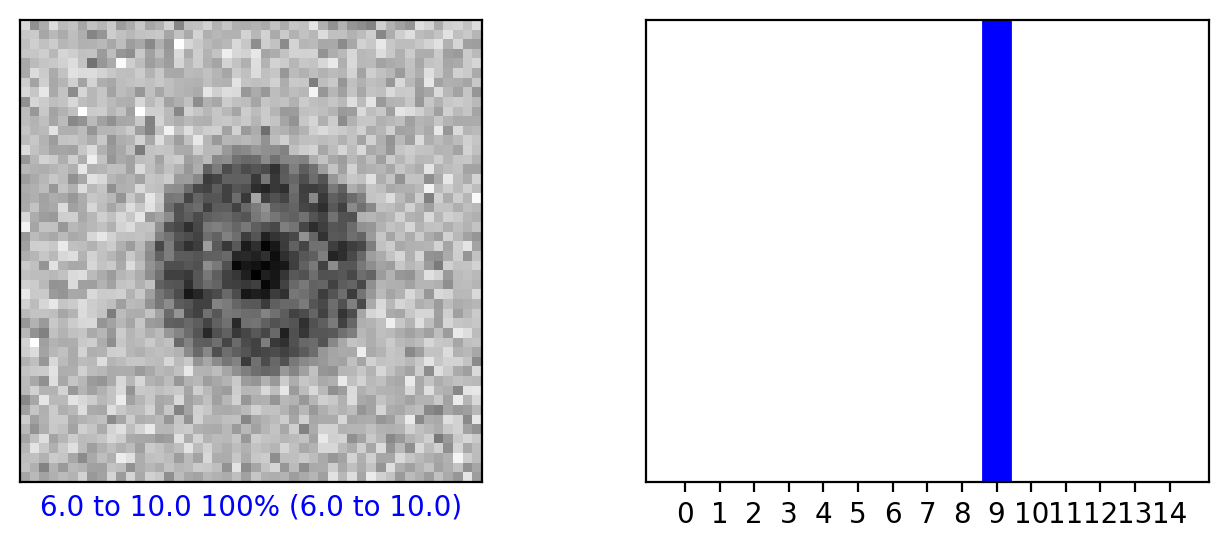

Difference between prediction and label: 0.772


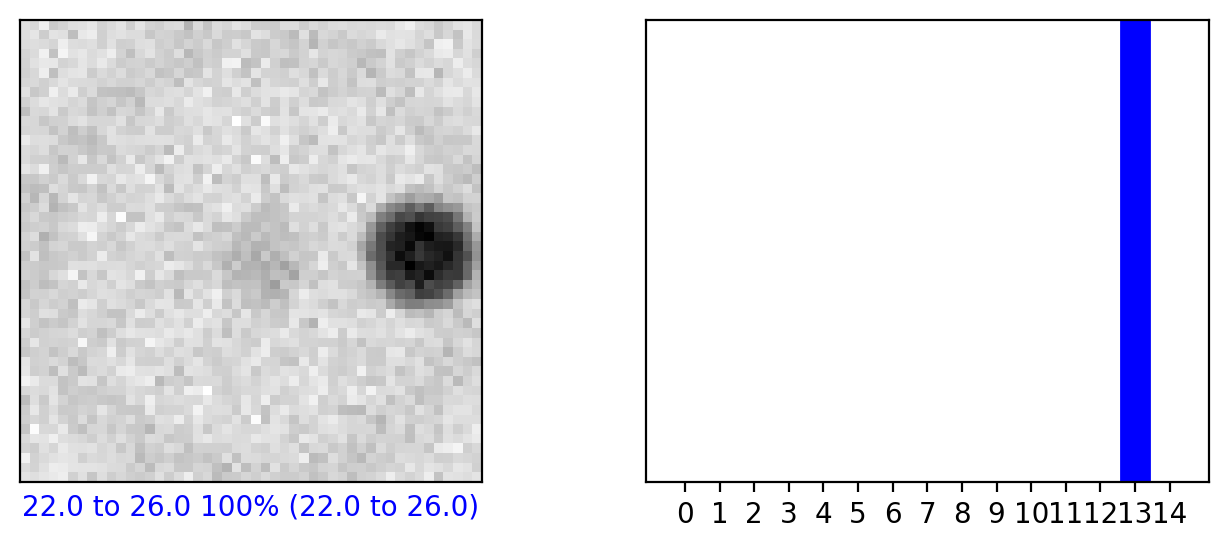

Difference between prediction and label: 1.01


In [27]:
# Display 16 sample predictions
for i in range(0, 16):
    image = test_images[i, ...]
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], indexed_labels, test_images[..., 0])
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  indexed_labels)
    plt.show()
    print(f'Difference between prediction and label: {abs(numpy.dot(predictions[i], class_dot) - numerical_labels[i]):.3}')

In [28]:
for i in range(5):
    tf.print(f'Predicted Value: {numpy.dot(predictions[i], class_dot)}\tTrue Value: {numerical_labels[i]}')
count = 0
for j in range(len(predictions)):
    if abs(numpy.dot(predictions[j], class_dot) - numerical_labels[j]) > 5:
        count += 1
100 * count / len(predictions)

Predicted Value: -19.221566451133924	True Value: -19.513805389404297
Predicted Value: 7.982475233913496	True Value: 6.248435974121094
Predicted Value: 3.999999990308674	True Value: 3.858722686767578
Predicted Value: 3.999977916276251	True Value: 3.7847862243652344
Predicted Value: 3.999999999971329	True Value: 4.080814361572266


13.216332378223496

In [29]:

# get the perentage of predictions which fall within 1 to 31 units of the actual value
for i in range(1, 31):
    count = 0
    for j in range(len(predictions)):
      if abs(numpy.dot(predictions[j], class_dot) - numerical_labels[j]) > i:
        count += 1
    print(f"With a acceptance radius of {i} units:\t {100 - (100 * count / len(predictions)):.3} % in range.")

With a acceptance radius of 1 units:	 36.5 % in range.
With a acceptance radius of 2 units:	 68.2 % in range.
With a acceptance radius of 3 units:	 77.0 % in range.
With a acceptance radius of 4 units:	 81.9 % in range.
With a acceptance radius of 5 units:	 86.8 % in range.
With a acceptance radius of 6 units:	 90.0 % in range.
With a acceptance radius of 7 units:	 92.0 % in range.
With a acceptance radius of 8 units:	 93.2 % in range.
With a acceptance radius of 9 units:	 94.1 % in range.
With a acceptance radius of 10 units:	 94.5 % in range.
With a acceptance radius of 11 units:	 95.0 % in range.
With a acceptance radius of 12 units:	 95.3 % in range.
With a acceptance radius of 13 units:	 95.6 % in range.
With a acceptance radius of 14 units:	 95.8 % in range.
With a acceptance radius of 15 units:	 96.0 % in range.
With a acceptance radius of 16 units:	 96.2 % in range.
With a acceptance radius of 17 units:	 96.3 % in range.
With a acceptance radius of 18 units:	 96.5 % in range.
W

In [30]:
# Display a histogram which gives an idea of the distribution of our predictions vs our true values 
import plotly.express as px

histogram_data = []
for i in range(len(predictions)):
  histogram_data.append(numerical_labels[i] - numpy.dot(predictions[i], class_dot))

fig = px.histogram(x=histogram_data, nbins=1000, width=600, height=400, labels={'x':'Difference bewteen True Value and CNN Prediction'})
fig.update_xaxes(tickvals=np.array([-60, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]),
                 tickangle=45)
fig.show()
print(f"Mean: {mean(histogram_data)}\t Standard Deviation: {np.std(histogram_data)}")

Mean: 0.03405756130814552	 Standard Deviation: 7.765766620635986
